In [117]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [118]:
%matplotlib inline

from session.sessions import selected_009266
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
np.set_printoptions(suppress=True)

In [119]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Session data

In [120]:
selected_009266

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [121]:
session = selected_009266[8]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009266_hippoSIT_2023-05-04_19-47-15'

### Choose target selective units

In [122]:
offset    = 7.25
bin_count = 30

In [123]:
tgt_units       = []
idxs_succ       = np.where(tgt_matrix[:, 4] == 1)[0]
tgt_succ_times  = tl[tgt_matrix[idxs_succ][:, 0]][:, 0]

for unit_name in unit_names:
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
    
    # based on success trials
    strain = spike_times[unit_name]
    bins, counts_enter = get_spike_counts(strain, tgt_succ_times, hw=offset, bin_count=bin_count)
    zero_bin_idx = len(bins[bins < 0]) - 1

    if counts_enter[zero_bin_idx] > shuffled[zero_bin_idx][3]: #or \
        #counts_enter[zero_bin_idx + 1] > shuffled[zero_bin_idx + 1][3]:
        tgt_units.append(unit_name)
        
print("%d units selected" % len(tgt_units))

14 units selected


### Compute onset population firing rates

In [124]:
offset = 0.25  # sec

# get FR means at onset
means_at_onset = np.zeros(len(tgt_units))
for i, unit_name in enumerate(tgt_units):
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
    bins = shuffled[:, 0]
    zero_bin_idx = len(bins[bins < 0]) - 1
    means_at_onset[i] = shuffled[zero_bin_idx][1]  # mean

# compute population mean matrix at target onsets
rel_frs = np.zeros( (len(tgt_matrix), len(tgt_units)))
labels  = np.array([0 if int(unit_name[0]) < 3 else 1 for unit_name in tgt_units])
for i, tgt_record in enumerate(tgt_matrix):
    entrance_time  = tl[tgt_record[0]][0]
    
    for j, unit_name in enumerate(tgt_units):
        spk_times = spike_times[unit_name]
        spike_count = spk_times[(spk_times > entrance_time - offset) & (spk_times < entrance_time + offset)]
        fr = len(spike_count) / (2*offset)  # actual firing
        rel_fr = fr / means_at_onset[j]     # relative to mean
        rel_frs[i, j] = rel_fr

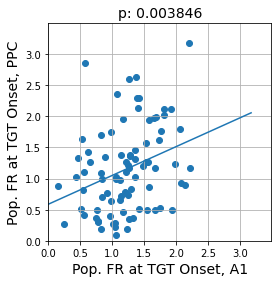

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

area_1_idxs = np.where(labels == 0)[0]
area_2_idxs = np.where(labels == 1)[0]
means_1 = rel_frs[:, area_1_idxs].mean(axis=1)
means_2 = rel_frs[:, area_2_idxs].mean(axis=1)
d_max = means_1.max() if means_1.max() > means_2.max() else means_2.max()
regress = stats.linregress(means_1, means_2)
x = np.array([0, d_max])
y = regress[0] * x + regress[1]

ax.scatter(means_1, means_2)
ax.plot(x, y)
ax.set_xlim(0, 1.1*d_max)
ax.set_ylim(0, 1.1*d_max)
ax.set_title("p: %4f" % regress[3], fontsize=14)
ax.set_xlabel('Pop. FR at TGT Onset, %s' % areas[0], fontsize=14)
ax.set_ylabel('Pop. FR at TGT Onset, %s' % areas[1], fontsize=14)
ax.grid()